# Detecting Technosignatures with SOMs & Doppler Drift Search

# 1 Accessing and Preparing the Data

## 1.1 Download Breakthrough Listen Data

For the initial run through I have chosen a random, small data file (renamed to TEST.h5) from Breakthrough Listen Open Data Archive: http://seti.berkeley.edu/opendata

## 1.2 Install Required Software

In [1]:
#pip install -U git+https://github.com/UCBerkeleySETI/blimpy
#pip install minisom
#pip install --user -U turbo_seti

## Loading the data:

In [2]:
import numpy as np
import pandas as pd

In [3]:
import pylab as plt

In [4]:
from blimpy.waterfall import Waterfall
fb = Waterfall('TEST.h5')
fb.info()
data = fb.data


--- File Info ---
DIMENSION_LABELS :   ['frequency' 'feed_id' 'time']
        az_start :                              0.0
       data_type :                                1
            fch1 :                2802.83203125 MHz
            foff :         -0.00286102294921875 MHz
      machine_id :                               20
           nbits :                               32
          nchans :                           351232
            nifs :                                1
     source_name :                         Hip15477
         src_dej :                     -6:48:04.216
         src_raj :                      3:19:33.977
    telescope_id :                                6
           tsamp :               1.0737418239999998
   tstart (ISOT) :          2016-09-04T09:48:36.000
    tstart (MJD) :                      57635.40875
        za_start :                              0.0

Num ints in file :                              273
      File shape :                 (273, 1, 

In [5]:
%matplotlib inline

extracting integration 0...


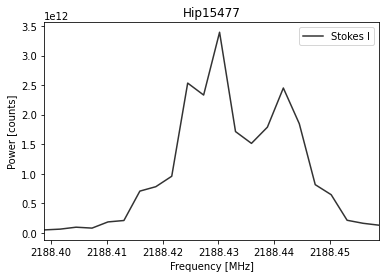

In [6]:
fb.plot_spectrum(f_start=2188.4, f_stop=2188.46)

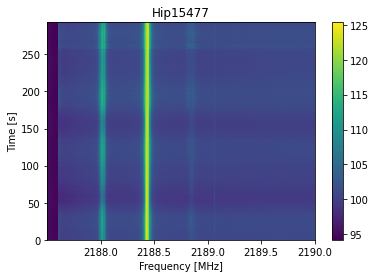

In [7]:
fb.plot_waterfall(f_start=2187.5, f_stop=2190)

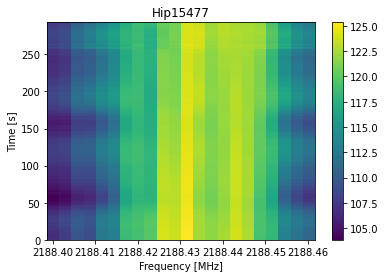

In [8]:
# Zoom into spike of intensity
fb.plot_waterfall(f_start=2188.4, f_stop=2188.46)

### Normalize the signal intensities from the waterfall plots.



In [9]:
# 2. Extract data with correct dimension handling
raw = fb.data[:, 0, :]   # (freq, time)
data = raw.T             # (time, freq)  -  required for SOM

# 3. Row-normalize safely
def row_normalize_safe(data):
    normalized = []
    for row in data:
        ptp = np.ptp(row)
        if ptp < 1e-6:
            continue
        norm_row = (row - np.min(row)) / ptp
        normalized.append(norm_row)
    return np.array(normalized)

data = row_normalize_safe(data)
print("Data shape:", data.shape)

print(len(data))

Data shape: (351232, 273)
351232


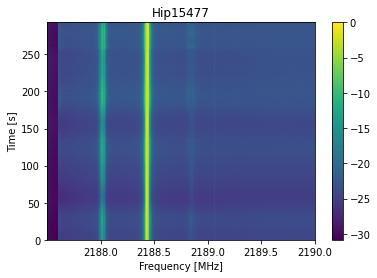

In [10]:
fb.data[:] = row_normalize_safe(fb.data) 

fb.plot_waterfall(f_start=2187.5, f_stop=2190)

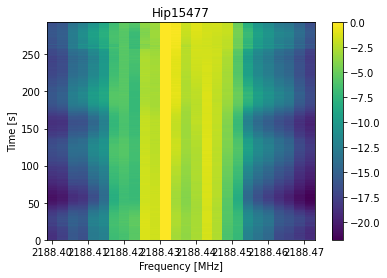

In [11]:
fb.plot_waterfall(f_start=2188.4, f_stop=2188.47)

# 2. Clustering Signals with Self-Organizing Maps (SOMs)

##  2.1. Why Use SOMs?

- Groups similar signals together in a 2D grid.
- Helps distinguish real signals from RFI (radio frequency interference).
- Prepares data for further anomaly detection (TurboSETI doppler drift in this case).

## 2.2 Steps to Apply SOMs

The data is already normalised, so we can now proceed with training the SOM. This datafile has roughly 350,000 entries, so an SOM of size 3x3 or 4x4 seems appropriate.

### 2.2.1. Train SOM

In [12]:
from minisom import MiniSom
som = MiniSom(x=4, y=4, input_len=data.shape[1], sigma=1.0, learning_rate=0.05)
som.random_weights_init(data) # 
som.train(data, num_iteration=1000)

In [13]:
data.shape

(351232, 273)

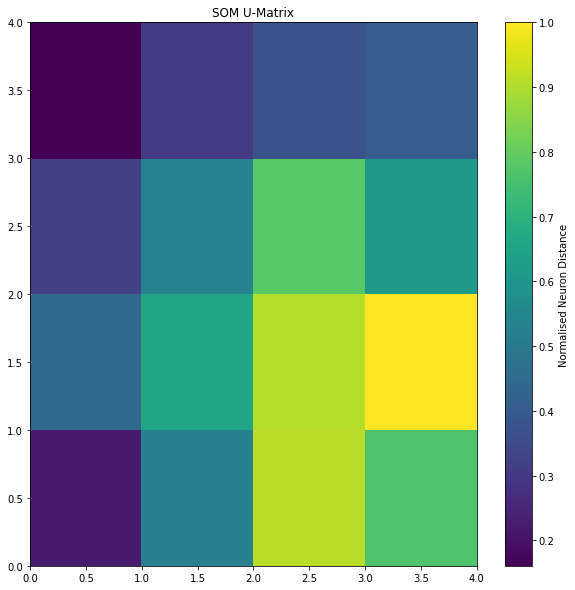

In [14]:
umat = som.distance_map().T
plt.figure(figsize=(10, 10))
plt.pcolor(umat, cmap='viridis')
plt.colorbar(label='Normalised Neuron Distance')
plt.title('SOM U-Matrix')
plt.show()
# bright areas have a larger neuron distance, indicating an anomoly
# dim areas have lower neuron distance, indicating clusters

### 2.2.2 Visualize the clustered signals to identify anomalous clusters.


In [15]:
from collections import defaultdict

bmu_counts = defaultdict(int)
bmu_indices = []

for i, x in enumerate(data):
    bmu = som.winner(x)
    bmu_counts[bmu] += 1
    bmu_indices.append(bmu)

In [16]:
threshold_l = 2
low_pop_nodes_l = {node for node, count in bmu_counts.items() if count < threshold_l}

threshold_u = 350000/6.5
low_pop_nodes_u = {node for node, count in bmu_counts.items() if count > threshold_u}

In [17]:
outliers = [data[i] for i, bmu in enumerate(bmu_indices) if bmu in (low_pop_nodes_u or low_pop_nodes_l) ]
print(f"Found {len(outliers)} potential outliers.")

Found 63754 potential outliers.


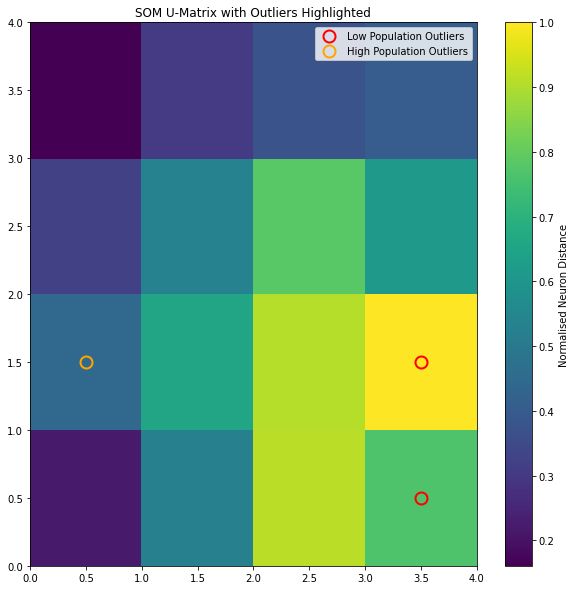

In [18]:
plt.figure(figsize=(10, 10))
plt.pcolor(umat, cmap='viridis')
plt.colorbar(label='Normalised Neuron Distance')

# Highlight low-pop nodes
for (x, y) in low_pop_nodes_l:
    plt.plot(x + 0.5, y + 0.5, 'ro', markersize=12, markeredgewidth=2, markerfacecolor='none',label='Low Population Outliers')
# Highlight high-pop nodes
for (x, y) in low_pop_nodes_u:
    plt.plot(x + 0.5, y + 0.5, 'o',color='orange', markersize=12, markeredgewidth=2, markerfacecolor='none',label='High Population Outliers')
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
unique = dict.fromkeys(labels)
new_handles = [handles[labels.index(label)] for label in unique]

# Set legend
plt.legend(new_handles, unique.keys())
plt.title('SOM U-Matrix with Outliers Highlighted')
plt.show()
# bright areas have a larger neuron distance, indicating an anomoly
# dim areas have lower neuron distance, indicating clusters

Outlier nodes: [[0 1]
 [3 1]
 [3 0]]


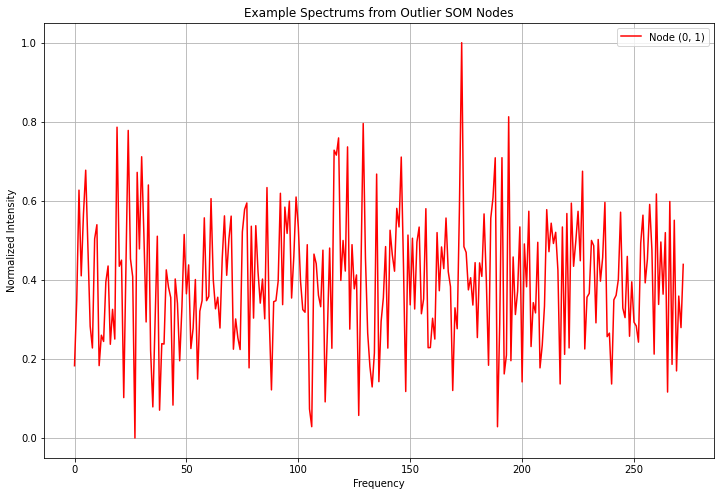

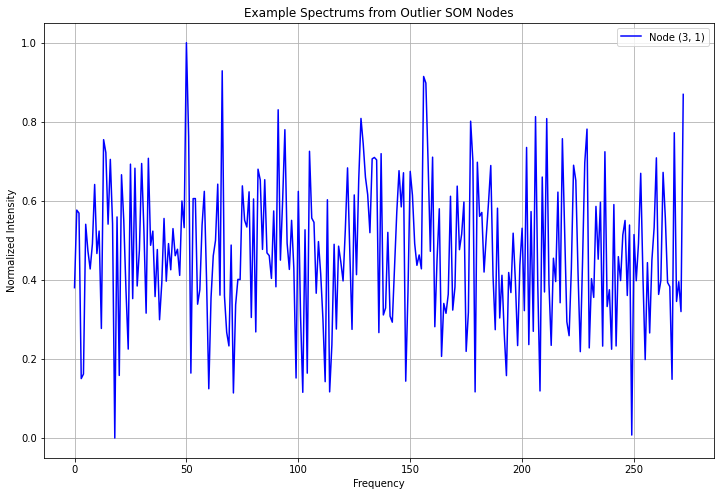

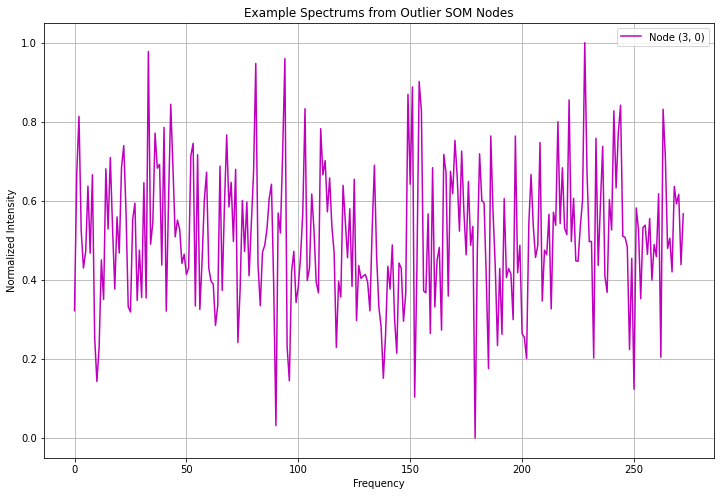

In [19]:
arr_u = np.array(list(low_pop_nodes_u))
arr_l = np.array(list(low_pop_nodes_l))
outlier_nodes = np.vstack((arr_u, arr_l))

colours = ['r','b','m','black','c']

print(f"Outlier nodes: {outlier_nodes}")

# Map each data sample to a SOM node
mapped_nodes = np.array([som.winner(d) for d in data])

# For each outlier node, find data samples that map there
example_spectrums = []
for node in outlier_nodes:
    matching_indices = np.where((mapped_nodes == node).all(axis=1))[0]
    if len(matching_indices) > 0:
        example_spectrums.append((node, data[matching_indices[0]]))  # Take the first match

# Plot example spectrums
for i, (node, spectrum) in enumerate(example_spectrums[:3]):  # Limit to first 3 for clarity
    plt.figure(figsize=(12, 8))
    plt.plot(spectrum,color=colours[i] ,label=f"Node {tuple(node)}")
    plt.title("Example Spectrums from Outlier SOM Nodes")
    plt.xlabel("Frequency")
    plt.ylabel("Normalized Intensity")
    plt.legend()
    plt.grid(True)
plt.show()

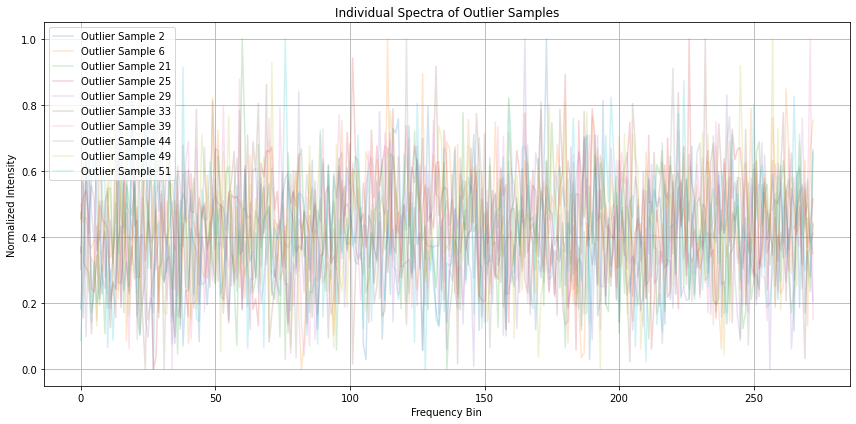

In [20]:
outlier_indices = []
for node in outlier_nodes:
    matches = np.where((mapped_nodes == node).all(axis=1))[0]
    outlier_indices.extend(matches)

# Sort indices to retain temporal order (optional, for better visual flow)
outlier_indices = sorted(outlier_indices)

# Stack spectrums of outlier samples into a matrix (time, frequency)
outlier_spectrogram_data = data[outlier_indices]  
plt.figure(figsize=(12, 6))
for i, idx in enumerate(outlier_indices[:10]):
    plt.plot(data[idx], label=f"Outlier Sample {idx}",alpha=0.2)
plt.title("Individual Spectra of Outlier Samples")
plt.xlabel("Frequency Bin")
plt.ylabel("Normalized Intensity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

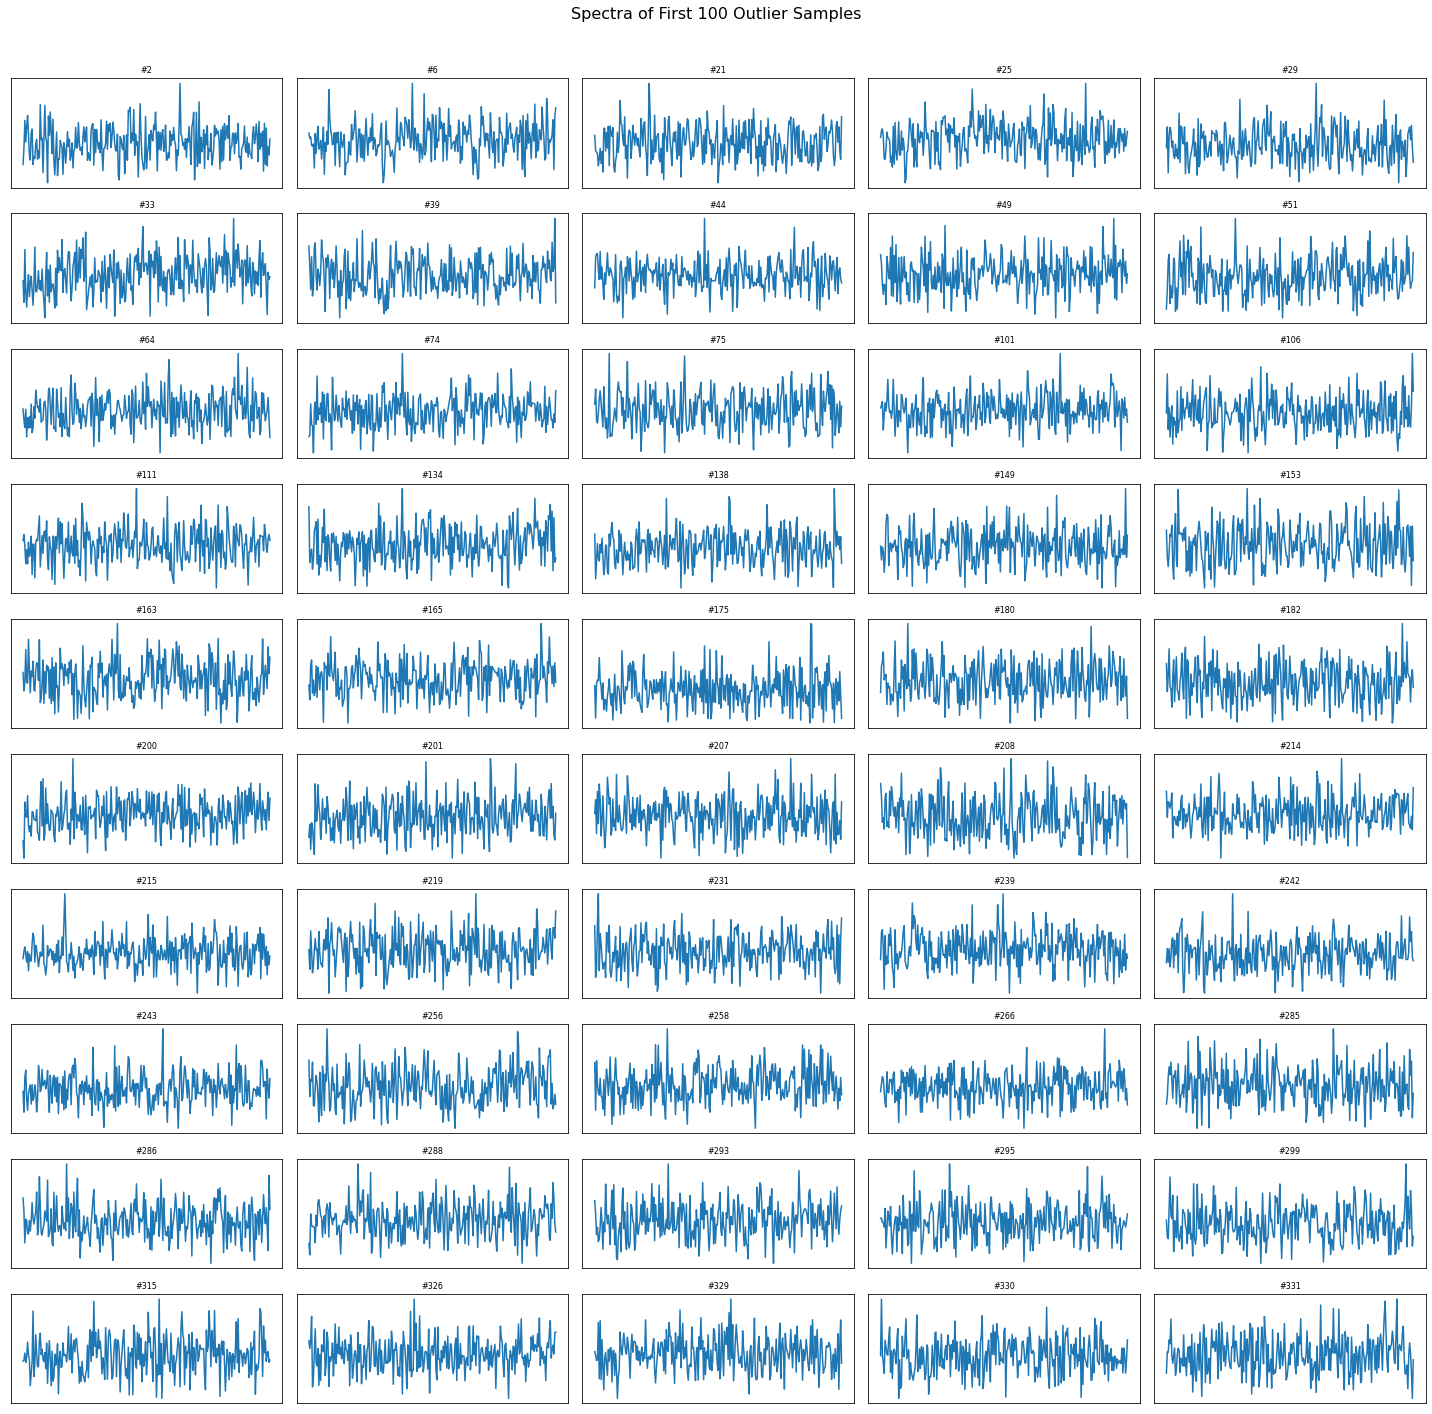

In [21]:
#Plot the first 100 outlier spectra
num_samples = min(50, len(outlier_indices))
cols = 5
rows = int(np.ceil(num_samples / cols))

plt.figure(figsize=(20, 2 * rows))

for i in range(num_samples):
    idx = outlier_indices[i]
    plt.subplot(rows, cols, i + 1)
    plt.plot(data[idx])
    plt.title(f"#{idx}", fontsize=8)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

plt.suptitle("Spectra of First 100 Outlier Samples", fontsize=16)
plt.subplots_adjust(top=0.93)  # Space for suptitle
plt.show()


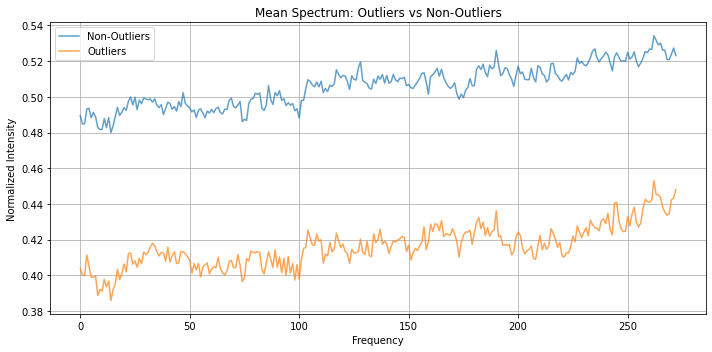

In [22]:
# Get non-outlier indices
all_indices = np.arange(len(data))
non_outlier_indices = list(set(all_indices) - set(outlier_indices))

mean_outlier = np.mean(data[outlier_indices], axis=0)
mean_non_outlier = np.mean(data[non_outlier_indices], axis=0)

plt.figure(figsize=(10, 5))
plt.plot(mean_non_outlier, label="Non-Outliers", alpha=0.7)
plt.plot(mean_outlier, label="Outliers", alpha=0.7)
plt.title("Mean Spectrum: Outliers vs Non-Outliers")
plt.xlabel("Frequency")
plt.ylabel("Normalized Intensity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

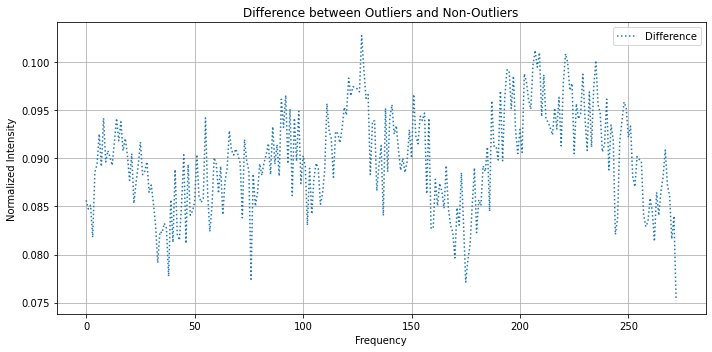

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(mean_non_outlier-mean_outlier,':',label='Difference')
plt.title("Difference between Outliers and Non-Outliers")
plt.xlabel("Frequency")
plt.ylabel("Normalized Intensity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

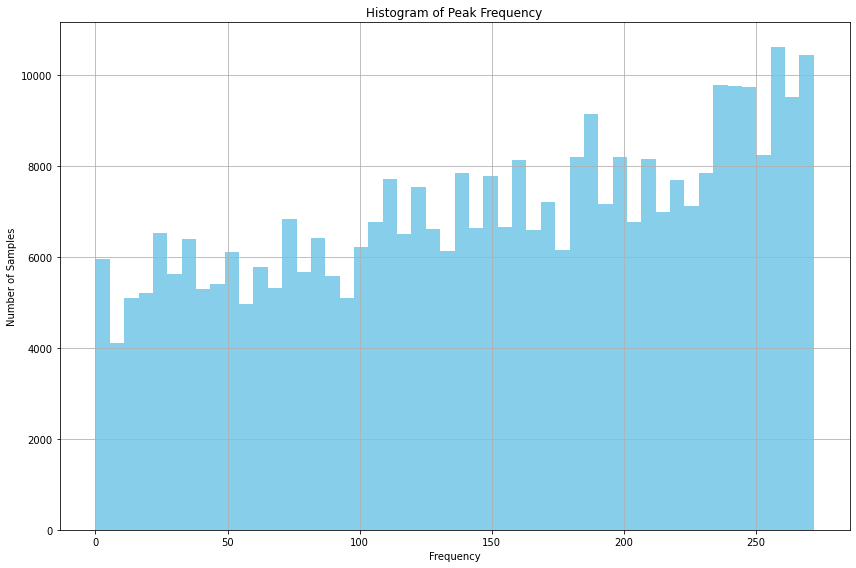

In [24]:
# Where do spectra tend to peak?
peak_bins = [np.argmax(row) for row in data]
plt.figure(figsize=(12, 8))
plt.hist(peak_bins, bins=50,histtype='bar', linewidth=1.5,color='skyblue')
plt.title("Histogram of Peak Frequency")
plt.xlabel("Frequency")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.tight_layout()
plt.show()

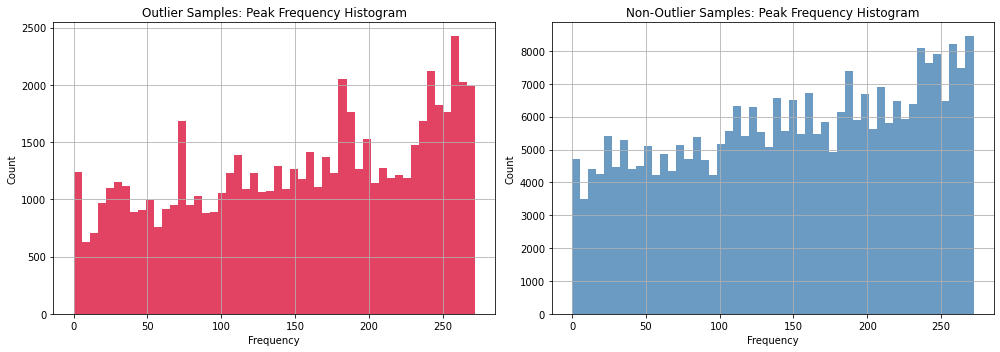

In [25]:
peak_bins_outliers = [np.argmax(data[i]) for i in outlier_indices]

# Compute for non-outliers
all_indices = np.arange(len(data))
non_outlier_indices = list(set(all_indices) - set(outlier_indices))
peak_bins_non_outliers = [np.argmax(data[i]) for i in non_outlier_indices]

# Plot the histograms side-by-side
plt.figure(figsize=(14, 5))

# Outliers
plt.subplot(1, 2, 1)
plt.hist(peak_bins_outliers, bins=50, color='crimson', alpha=0.8)
plt.title("Outlier Samples: Peak Frequency Histogram")
plt.xlabel("Frequency")
plt.ylabel("Count")
plt.grid(True)

# Non-Outliers
plt.subplot(1, 2, 2)
plt.hist(peak_bins_non_outliers, bins=50, color='steelblue', alpha=0.8)
plt.title("Non-Outlier Samples: Peak Frequency Histogram")
plt.xlabel("Frequency")
plt.ylabel("Count")
plt.grid(True)

plt.tight_layout()
plt.show()

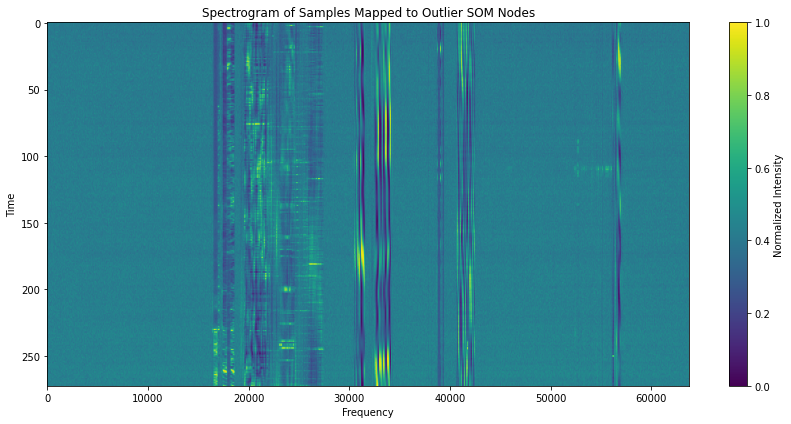

In [26]:
outlier_indices = []
for node in outlier_nodes:
    matches = np.where((mapped_nodes == node).all(axis=1))[0]
    outlier_indices.extend(matches)

# Sort indices to retain temporal order (optional, for better visual flow)
outlier_indices = sorted(outlier_indices)

# Stack spectrums of outlier samples into a matrix (time, frequency)
outlier_spectrogram_data = data[outlier_indices]  

# Plot as a spectrogram
plt.figure(figsize=(12, 6))
plt.imshow(outlier_spectrogram_data.T, aspect='auto', cmap='viridis', origin='upper')
plt.title("Spectrogram of Samples Mapped to Outlier SOM Nodes")
plt.ylabel("Time")
plt.xlabel("Frequency")
plt.colorbar(label="Normalized Intensity")
plt.tight_layout()
plt.show()

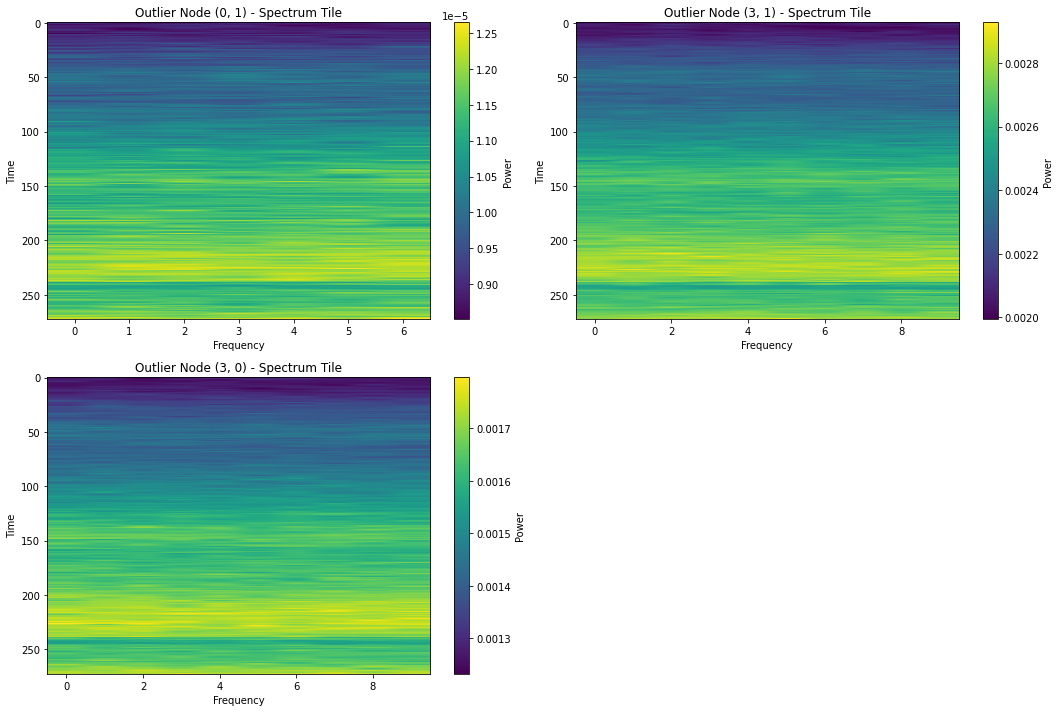

In [27]:
window_size = 10  # Number of time steps to show (rows around the outlier)

plt.figure(figsize=(15, 10))

num_plots = min(4, len(example_spectrums))  # Limit to 4 for clarity
for i, (node, _) in enumerate(example_spectrums[:num_plots]):
    # Find an index for a data sample mapped to this node
    idx = np.where((mapped_nodes == node).all(axis=1))[0][0]
    
    # Reverse transpose to get original orientation: (freq, time)
    start = max(0, idx - window_size // 2)
    end = min(raw.shape[1], idx + window_size // 2)
    tile = raw[:, start:end]  # raw is (freq, time)

    plt.subplot(2, 2, i+1)
    plt.imshow(tile, aspect='auto', origin='upper', cmap='viridis')
    #plt.imshow(tile, aspect='auto', cmap='viridis', origin='upper')
    plt.title(f"Outlier Node {tuple(node)} - Spectrum Tile")
    plt.ylabel("Time")
    plt.xlabel("Frequency")
    plt.colorbar(label="Power")

plt.tight_layout()
plt.show()

In [28]:
# Each column in the heatmap is a spectrum from one time slice that was flagged as unusual by the SOM.

### 2.2.2 Extract signals only from anomalous SOM clusters. Save these signals as a separate HDF5 file


In [29]:
outlier_indices = [i for i, bmu in enumerate(bmu_indices) if bmu in low_pop_nodes_l]

In [30]:
n_times, n_freqs = data.shape

# Get time and frequency axes
f_start, f_stop = fb.header['fch1'], fb.header['fch1'] - fb.header['foff'] * n_freqs
frequencies = np.linspace(f_start, f_stop, n_freqs)
time_axis = np.arange(n_times) * fb.header['tsamp']  # time in seconds

In [31]:
# Filter the original dataset
filtered_data = data[outlier_indices] 

In [32]:
import h5py

In [33]:
# Load original Waterfall
fb = Waterfall('TEST.h5')

# Get original data shape and metadata
original_data = fb.data
header = fb.header
n_times, n_beams, n_freqs = original_data.shape

# Extract outlier time indices
# `outlier_indices` already defined earlier
outlier_data = original_data[:, :, outlier_indices]

# Save outliers to new HDF5 file
output_filename = 'TEST_outlierJH.h5'


with h5py.File(output_filename, 'w') as f:
    # Copy attributes from the original file
    for key, val in fb.header.items():
        f.attrs[key] = val

    # Save outlier data
    dset = f.create_dataset('data', data=outlier_data, dtype='float32')

    # Also copy frequency/time metadata if needed
    f.attrs['fch1'] = header['fch1']
    f.attrs['foff'] = header['foff']
    f.attrs['nchans'] = header['nchans']
    f.attrs['tsamp'] = header['tsamp']

print(f"Outlier HDF5 saved as: {output_filename}")

Outlier HDF5 saved as: TEST_outlierJH.h5


# 3 Running Doppler Drift Search on Anomalous Clusters

TurboSETI requries a different local environment so these next steps are performed on a different notebook

##  3.1 Why Search for Doppler Drifting Signals?

- Technosignatures are expected to show narrowband signals with frequency drift due to the motion of a potential alien transmitter.
- TurboSETI detects these drifts efficiently.


## 3.2 Steps to Apply TurboSETI

- Denoise the data
- Read the filtered dataset and apply TurboSETI
- Analyze the detected signals and compare against known RFI sources.


# 4 Extracting & Analyzing Detected Signals

## 4.1 Interpreting Results 

- Waterfall plots help visualize signals over time.
- Histogram of detected drift rates can reveal patterns.
- On/Off cadence analysis verifies true technosignatures (signals that appear only when the telescope is pointing at a target).


## 4.2  Filtering Out RFI

- Compare detected signals with known terrestrial sources (e.g., WiFi, satellites).
- Cross-match detections across different telescopes (GBT, Parkes).